In [1]:
## for comet
#from comet_ml import Experiment

import numpy
from tqdm import tqdm
from collections import OrderedDict
from dataset import ptb
import sys
import os
import pickle
import random
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
#device = 'cpu'
device = 'gpu'

np = numpy
if device == 'gpu':
    import cupy
    import cupyx
    np = cupy
print(f'Use {device}.')

Use gpu.


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, ndim=-1):
    x = x.astype('float64')
    if x.ndim == -1:
        ndim = len(x.shape) - 1
    c = x.max()
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x, axis=ndim)
    out = (exp_x.T / sum_exp_x).T
    return out.astype('f')

def cross_entropy_error(y, t, onehot=False):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    if not onehot:
        out = -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    else:
        out = -np.sum(np.dot(t, np.log(y + 1e-7))) / batch_size
    return out

def numerical_diff(f, x, i):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_diff2(f, x, i, j):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i, j] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_gradient(f, x):
    grad = np.zeros_like(x).astype(np.float128)
    n, m = x.shape
    for i in range(n):
        for j in range(m):
            grad[i, j] = numerical_diff2(f, x, i, j)
    return grad

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def to_cpu(x):
    if type(x) == numpy.ndarray:
        return x
    return cupy.asnumpy(x)

def to_gpu(x):
    if type(x) == cupy.ndarray:
        return x
    return cupy.array(x)

def to_device(x, device=device):
    if device == 'gpu':
        return to_gpu(x)
    else:
        return to_cpu(x)

In [4]:
class Adam:
    def __init__(self, shape, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0

    def update(self, w, dw):
        self.t += 1
        self.m = (self.beta1 * self.m) + (1 - self.beta1) * dw
        self.v = (self.beta2 * self.v) + (1 - self.beta2) * dw**2
        mh = self.m / (1 - self.beta1 ** self.t)
        vh = self.v / (1 - self.beta2 ** self.t)
        w -= self.alpha * (mh / (np.sqrt(vh) + self.epsilon))

class AdamContainer:
    def __init__(self, layers, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.params = []
        for params in [layer.params for layer in layers]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in layers]:
            for grad in grads:
                self.grads.append(grad)
        self.adams = [Adam(param.shape, alpha, beta1, beta2, epsilon) for param in self.params]
    
    def update(self):
        for adam, param, grad in zip(self.adams, self.params, self.grads):
            adam.update(param, grad)

In [5]:
class BaseLayer:
    def __init__(self):
        self.params = None
        self.grads = None
        
    def to_cpu(self):
        for param in self.params:
            param = to_cpu(param)
        for grad in self.grads:
            grad = to_cpu(grad)
            
    def to_gpu(self):
        for param in self.params:
            param = to_gpu(param)
        for grad in self.grads:
            grad = to_gpu(grad)

class Affine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
    
    def forward(self, x):
        w, b = self.params
        self.x = x
        return np.dot(x, w) + b
    
    def backward(self, dout):
        w = self.params[0]
        dx = np.dot(dout, w.T)
        self.grads[0] = self.dw = np.dot(self.x.T, dout)
        self.grads[1] = self.db = np.sum(dout, axis=0)
        return dx

class TimeAffine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
        self.layers = None
        self.cache = None
        
    def forward(self, xs):
        w, b = self.params
        N, T, D = xs.shape
        D, V = w.shape
        
        out = np.empty((N, T, V), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Affine(w, b)
            out[:,t,:] = layer.forward(xs[:,t,:])
            self.layers.append(layer)
        
        self.cache = (N, T, D, V)
        return out
    
    def backward(self, dout):
        N, T, D, V = self.cache
        
        out = np.empty((N, T, D), dtype='f')
        dw = np.empty((D, T, V), dtype='f')
        db = np.empty((T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            out[:,t,:] = layer.backward(dout[:,t,:])
            dw[:,t,:] = layer.dw
            db[t,:] = layer.db
        self.grads[0] = self.dw = dw.sum(axis=1)
        self.grads[1] = self.db = db.sum(axis=0)
        
        return out

class ReLU(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class Sigmoid(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx
    
class Softmax(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.y = softmax(x)
        return self.y
    
    def backward(self, dout):
        dx = self.y * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.y * sumdx
        return dx

class SoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1, onehot=False):
        batch_size = self.t.shape[0]
        if not onehot:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx *= dout
            dx = dx / batch_size
        else:
            dx = (self.y - self.t) / batch_size
        return dx

class TimeSoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.layers = None
        self.cache = None
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        # if ts is one-hot vector
        if ts.ndim == 3:
            ts = ts.argmax(axis=2).reshape(N, T)
        
        ys = np.empty(T, dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = SoftmaxWithLoss()
            ys[t] = layer.forward(xs[:,t,:], ts[:,t])
            self.layers.append(layer)
            
        loss = ys.sum() / T
        
        self.cache = (N, T, V)
        return loss
    
    def backward(self):
        N, T, V = self.cache
        dx = np.empty((N, T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            dx[:,t,:] = layer.backward()
        self.dx = dx / T
        
        return self.dx

class Dropout(BaseLayer):
    def __init__(self, ratio=0.5):
        self.params = []
        self.grads = []
        self.ratio = ratio
        self.mask = None
        self.train = True

    def forward(self, x):
        if self.train:
            self.mask = np.random.rand(*x.shape) > self.ratio
            self.mask = self.mask.astype('f') / (1.0 - self.ratio)
            return x * self.mask
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

class Embedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.idx = None
        
    def forward(self, idx):
        w = self.params[0]
        self.idx = idx
        return w[idx]
    
    def backward(self, dout):
        if device == 'gpu':
            add_at = cupyx.scatter_add
        else:
            add_at = np.add.at
            
        dw = self.grads[0]
        dw[...] = 0
        add_at(dw, self.idx, dout)
        self.grads[0] = self.dw = dw
        return None

class TimeEmbedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.layers = None
        
    def forward(self, xs):
        w = self.params[0]
        N, T = xs.shape
        V, D = w.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(w)
            out[:,t,:] = layer.forward(xs[:,t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        dw = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:,t,:])
            dw += layer.dw
        self.grads[0] = self.dw = dw
        
        return None

class RNN(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
    
    def forward(self, x, h_prev):
        wx, wh, b = self.params
        t = np.dot(h_prev, wh) + np.dot(x, wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        wx, wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - dh_next ** 2)
        db = np.sum(dt, axis=0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, wh.T)
        dwx = np.dot(x.T, dt)
        dx = np.dot(dt, wx.T)
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev

class TimeRNN(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        D, H = wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:], self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D, H = wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class LSTM(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        wx, wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(h_prev, wh) + np.dot(x, wx) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev,i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        wx, wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= 1 - g ** 2
        
        dA = np.hstack((df, dg, di, do))
        
        dwh = np.dot(h_prev.T, dA)
        dh_prev = np.dot(dA, wh.T)
        dwx = np.dot(x.T, dA)
        dx = np.dot(dA, wx.T)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev, dc_prev

class TimeLSTM(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh, self.c = None, None, None
        self.stateful = stateful
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        H = wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D = wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class BaseNetwork:
    def __init__(self):
        self.layers = None
        self.lastLayer = None
        self.adam = None
        
    def train(self, x, t):
        # forward
        loss = self.loss(x, t)
        
        # backward
        dout = self.lastLayer.backward()
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        self.update()
            
        return loss
    
    def update(self):
        for grads in [layer.grads for layer in self.layers.values()]:
            clip_grads(grads, self.max_grad)
        self.adam.update()
    
    def save(self, state_file_name = 'network.state.pkl'):
        params = self.adam.params.copy()
        for i, param in enumerate(params):
            params[i] = to_cpu(params[i])
            
        with open(state_file_name, 'wb') as f:
            pickle.dump(params, f)
            print(f'Saved: {state_file_name}')
            
    def load(self, state_file_name = 'network.state.pkl'):
        if os.path.exists(state_file_name):
            with open(state_file_name, 'rb') as f:
                params = pickle.load(f)
                for i, param in enumerate(params):
                    self.adam.params[i][:] = to_device(param, device)
                print(f'Loaded: {state_file_name}')

In [6]:
class Network(BaseNetwork):
    def __init__(self, vocab_size, wordvec_size, hidden_size, max_grad=5.0, dropout_ratio=0.1):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        self.max_grad = max_grad
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm1_wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm1_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm1_b = np.zeros(4 * H).astype('f')
        lstm2_wx = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm2_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm2_b = np.zeros(4 * H).astype('f')
        ## if use weight tying (require: H == D), comment-out this affine_w
        affine_w = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['Dropout1'] = Dropout(dropout_ratio)
        self.layers['LSTM1'] = TimeLSTM(lstm1_wx, lstm1_wh, lstm1_b, stateful=True)
        self.layers['Dropout2'] = Dropout(dropout_ratio)
        self.layers['LSTM2'] = TimeLSTM(lstm2_wx, lstm2_wh, lstm2_b, stateful=True)
        self.layers['Dropout3'] = Dropout(dropout_ratio)
        self.layers['Affine'] = TimeAffine(affine_w, affine_b)
        #self.layers['Affine'] = TimeAffine(embed_w.T, affine_b)  # weight tying
        self.lastLayer = TimeSoftmaxWithLoss()
        
        self.lstm_layers = [self.layers['LSTM1'], self.layers['LSTM2']]
        self.drop_layers = [self.layers['Dropout1'], self.layers['Dropout2'], self.layers['Dropout3']]
        
        self.adam = AdamContainer(list(self.layers.values()))
        
    def predict(self, x, train=False):
        for layer in self.drop_layers:
            layer.train = train
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t, train=True):
        y = self.predict(x, train)
        return self.lastLayer.forward(y, t)
    
    def reset_rnn_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [7]:
def load_data(file_path=None):
    if file_path is None or not os.path.exists(file_path):
        return ptb.load_data('train')
    
    words = (open(file_path).read().translate(
                str.maketrans({',':'','.':'','-':'',"'":'',':':'',';':'','!':'','?':''}))
                .lower().strip().split())

    word_to_id = {}
    id_to_word = {}
    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

def make_corpus(str):
    corpus = []
    word_to_id = {}
    id_to_word = {}
    for word in str.lower().strip().split():
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word
        corpus.append(word_to_id[word])
    return corpus, word_to_id, id_to_word

In [8]:
def cos_similarity(x, y):
    x = x / np.sqrt(np.sum(x ** 2))
    y = y / np.sqrt(np.sum(y ** 2))
    return np.dot(x, y)

def most_similar(word_to_id, id_to_word, word_matrix, queries=['you', 'say', 'good'], top=5):
    for query in queries:
        if query not in word_to_id:
            print(f'{query} is not found.')
            continue

        print(f'\n{query}')
        query_id = word_to_id[query]
        query_vec = word_matrix[query_id]

        vocab_size = len(word_matrix)
        similarity = np.zeros(vocab_size)
        for i in range(vocab_size):
            similarity[i] = cos_similarity(word_matrix[i], query_vec)

        count = 0
        for i in (-1 * similarity).argsort():
            if id_to_word[i.item()] == query:
                continue
            print(f' {id_to_word[i.item()]}: {similarity[i.item()]}')
            count += 1
            if count >= top:
                break

def generate_seq(network, start_id, sample_size=100):
    word_ids = [start_id]
    
    x = start_id
    while len(word_ids) < sample_size:
        x = np.array(x).reshape(1,1)
        score = network.predict(x)
        p = softmax(score.flatten())
        x = np.random.choice(len(p), size=1, p=p)
        word_ids.append(x.item())
        
    return word_ids

def print_generate_seq(network, word_to_id, id_to_word, start_word='you', load_state=True):
    start_id = word_to_id[start_word]
    network.reset_rnn_state()
    word_ids = generate_seq(network, start_id)
    network.reset_rnn_state()
    txt = ' '.join([id_to_word[i] for i in word_ids])
    txt = txt.replace('<eos>', '.\n')
    print(txt)

In [9]:
class Program1:
    def __init__(self):
        self.params = OrderedDict({'batch_size': 64, 'corpus_size': 202646,
                                  'wordvec_size': 512, 'hidden_size': 512,
                                  'time_size': 32, 'max_epoch': 100})
        self.losses = []
        self.ppl_list = []
        
    def __call__(self):
        ## for comet
        #experiment = Experiment()
        #experiment.log_parameters(self.params)
        
        corpus, word_to_id, id_to_word = load_data('dataset/tinyshakespare.txt')
        #corpus, word_to_id, id_to_word = load_data()
        print(f'max_corpus_size: {len(corpus)}')
        corpus = corpus[:self.params['corpus_size']]
        self.params['corpus_size'] = len(corpus)
        vocab_size = int(max(corpus) + 1)
        self.params['vocab_size'] = vocab_size
        
        self.corpus = corpus
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        
        xs = corpus[:-1]
        ts = corpus[1:]
        data_size = len(xs)
        
        for key in self.params.keys() :
            print(f'{key}: {self.params[key]}')
        batch_size, corpus_size, wordvec_size, hidden_size, time_size, max_epoch, vocab_size = self.params.values()

        self.net = Network(vocab_size, wordvec_size, hidden_size)
        self.net.load()
        
        print()
        print_generate_seq(self.net, word_to_id, id_to_word)
        print()
        most_similar(word_to_id, id_to_word, self.net.layers['Embedding'].params[0])
        print()
        
        max_iters = data_size // (batch_size * time_size)
        time_idx = 0
        total_loss = 0
        loss_count = 0
        
        jump = (corpus_size - 1) // batch_size
        offsets = [i * jump for i in range(batch_size)]
        
        for epoch in range(max_epoch):
            for ite in tqdm(range(max_iters)):
                batch_x = np.empty((batch_size, time_size), dtype='i')
                batch_t = np.empty((batch_size, time_size), dtype='i')
        
                for t in range(time_size):
                    for i, offset in enumerate(offsets):
                        batch_x[i, t] = xs[(offset + time_idx) % data_size]
                        batch_t[i, t] = ts[(offset + time_idx) % data_size]
                    time_idx += 1
                
                loss = self.net.train(batch_x, batch_t)
                self.losses.append(loss.tolist())
                total_loss += loss
                loss_count += 1
                
                ## for comet
                #experiment.log_metric('loss', loss, step=epoch*max_iters-(max_iters-ite))
            
            ppl = float(np.exp(total_loss / loss_count))
            print(f'| epoch {epoch+1} | total_loss {total_loss} | perplexity {ppl}')
            self.ppl_list.append(ppl)
            if len(self.ppl_list) > 1 and min(self.ppl_list[:-1]) >= ppl:
                self.net.save(f'network.state.ppl_min.pkl')
            
            time_idx, total_loss, loss_count = 0, 0, 0
            
            ## for comet
            #experiment.log_metric('perplexity', ppl, step=epoch*max_iters)
        
        print()
        print_generate_seq(self.net, word_to_id, id_to_word)
        print()
        most_similar(word_to_id, id_to_word, self.net.layers['Embedding'].params[0])
        
        self.net.save()

        ## for comet
        #experiment.end()

In [10]:
program = Program1()
if __name__ == '__main__':
    program()

max_corpus_size: 202646
batch_size: 64
corpus_size: 202646
wordvec_size: 512
hidden_size: 512
time_size: 32
max_epoch: 100
vocab_size: 12848

you severals sacrifices taskd woodville christophero shilling sands perverse betid flourishd tuners medler peaces stored treasury staring prayed integrity falconbridge taste agenor fiddlestick trifling pardond grief mercutio betrothd put doubted distressd joint wagoner arrested satisfy dreaded holier digest jacob between signet fares drugs fatherinlaw lieutenant cannons dallied answer therefore song outdares signories kentishmen holdinganchor bespice speech paltering iv mammet mean complete herd food twangling hurdle wrung condemn dependency shrouds bagot enfoldings hearkens losses coursers nicely leicestershire gibingly forms unfurnish fellowships open wonderd said ages flatter urgent upstaringthen dog handed sparkling blusters already deed if forges tiger looking debts forego digressing


you
 conferring: 0.1741846203804016
 play: 0.17240743339

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.26it/s]


| epoch 1 | total_loss 848.32958984375 | perplexity 5746.94970703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.02it/s]


| epoch 2 | total_loss 841.87255859375 | perplexity 5380.49755859375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.90it/s]


| epoch 3 | total_loss 841.6493530273438 | perplexity 5368.25830078125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


| epoch 4 | total_loss 841.0814208984375 | perplexity 5337.236328125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


| epoch 5 | total_loss 839.991943359375 | perplexity 5278.2314453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.56it/s]


| epoch 6 | total_loss 839.78369140625 | perplexity 5267.02783203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.49it/s]


| epoch 7 | total_loss 839.4341430664062 | perplexity 5248.275390625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


| epoch 8 | total_loss 838.4376220703125 | perplexity 5195.17578125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


| epoch 9 | total_loss 837.173828125 | perplexity 5128.61083984375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]


| epoch 10 | total_loss 835.77734375 | perplexity 5056.04736328125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:35<00:00,  2.75it/s]


| epoch 11 | total_loss 834.5205688476562 | perplexity 4991.62255859375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


| epoch 12 | total_loss 833.416748046875 | perplexity 4935.712890625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.05it/s]


| epoch 13 | total_loss 832.3846435546875 | perplexity 4884.005859375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]


| epoch 14 | total_loss 831.3765869140625 | perplexity 4834.02490234375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.14it/s]


| epoch 15 | total_loss 830.368896484375 | perplexity 4784.5732421875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.50it/s]


| epoch 16 | total_loss 829.2969970703125 | perplexity 4732.5263671875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:35<00:00,  2.77it/s]


| epoch 17 | total_loss 828.4402465820312 | perplexity 4691.33349609375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


| epoch 18 | total_loss 827.7034912109375 | perplexity 4656.197265625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


| epoch 19 | total_loss 826.9309692382812 | perplexity 4619.63623046875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.46it/s]


| epoch 20 | total_loss 826.23388671875 | perplexity 4586.8916015625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.46it/s]


| epoch 21 | total_loss 825.58642578125 | perplexity 4556.689453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]


| epoch 22 | total_loss 824.8977661132812 | perplexity 4524.779296875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


| epoch 23 | total_loss 824.4203491210938 | perplexity 4502.791015625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.50it/s]


| epoch 24 | total_loss 823.8753051757812 | perplexity 4477.81689453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


| epoch 25 | total_loss 823.3408813476562 | perplexity 4453.46533203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.90it/s]


| epoch 26 | total_loss 822.9443969726562 | perplexity 4435.4853515625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.36it/s]


| epoch 27 | total_loss 822.4093627929688 | perplexity 4411.333984375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.39it/s]


| epoch 28 | total_loss 821.9672241210938 | perplexity 4391.4755859375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.48it/s]


| epoch 29 | total_loss 821.6908569335938 | perplexity 4379.109375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


| epoch 30 | total_loss 821.40234375 | perplexity 4366.236328125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]


| epoch 31 | total_loss 821.0428466796875 | perplexity 4350.2470703125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


| epoch 32 | total_loss 820.6280517578125 | perplexity 4331.87353515625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.49it/s]


| epoch 33 | total_loss 820.3253173828125 | perplexity 4318.513671875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:34<00:00,  2.87it/s]


| epoch 34 | total_loss 819.912841796875 | perplexity 4300.376953125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


| epoch 35 | total_loss 819.5875854492188 | perplexity 4286.12451171875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.23it/s]


| epoch 36 | total_loss 819.207763671875 | perplexity 4269.544921875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]


| epoch 37 | total_loss 818.9916381835938 | perplexity 4260.14111328125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.14it/s]


| epoch 38 | total_loss 818.6702880859375 | perplexity 4246.19580078125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


| epoch 39 | total_loss 818.3541870117188 | perplexity 4232.5185546875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.15it/s]


| epoch 40 | total_loss 818.0499877929688 | perplexity 4219.40478515625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


| epoch 41 | total_loss 817.6658325195312 | perplexity 4202.89453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.41it/s]


| epoch 42 | total_loss 817.3495483398438 | perplexity 4189.35302734375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]


| epoch 43 | total_loss 817.1996459960938 | perplexity 4182.94921875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


| epoch 44 | total_loss 816.684814453125 | perplexity 4161.0341796875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s]


| epoch 45 | total_loss 816.3857421875 | perplexity 4148.35498046875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


| epoch 46 | total_loss 816.0047607421875 | perplexity 4132.25732421875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.14it/s]


| epoch 47 | total_loss 815.6754150390625 | perplexity 4118.39306640625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


| epoch 48 | total_loss 815.4068603515625 | perplexity 4107.12451171875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.39it/s]


| epoch 49 | total_loss 815.2159423828125 | perplexity 4099.13037109375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s]


| epoch 50 | total_loss 814.89453125 | perplexity 4085.708740234375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


| epoch 51 | total_loss 814.6229858398438 | perplexity 4074.401123046875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.18it/s]


| epoch 52 | total_loss 814.46533203125 | perplexity 4067.855224609375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.18it/s]


| epoch 53 | total_loss 814.02978515625 | perplexity 4049.813232421875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.49it/s]


| epoch 54 | total_loss 813.8841552734375 | perplexity 4043.800537109375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.04it/s]


| epoch 55 | total_loss 813.52197265625 | perplexity 4028.884033203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.95it/s]


| epoch 56 | total_loss 813.225341796875 | perplexity 4016.707275390625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.93it/s]


| epoch 57 | total_loss 812.9697265625 | perplexity 4006.244140625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:36<00:00,  2.68it/s]


| epoch 58 | total_loss 812.6646728515625 | perplexity 3993.79296875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.88it/s]


| epoch 59 | total_loss 812.3152465820312 | perplexity 3979.577392578125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


| epoch 60 | total_loss 811.9488525390625 | perplexity 3964.72802734375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.90it/s]


| epoch 61 | total_loss 811.6358032226562 | perplexity 3952.08154296875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


| epoch 62 | total_loss 811.41455078125 | perplexity 3943.170654296875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


| epoch 63 | total_loss 811.0205688476562 | perplexity 3927.347900390625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  2.99it/s]


| epoch 64 | total_loss 810.9473266601562 | perplexity 3924.416259765625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


| epoch 65 | total_loss 810.8486938476562 | perplexity 3920.466064453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


| epoch 66 | total_loss 810.8196411132812 | perplexity 3919.3076171875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.52it/s]


| epoch 67 | total_loss 810.2654418945312 | perplexity 3897.205078125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.15it/s]


| epoch 68 | total_loss 809.8743286132812 | perplexity 3881.681884765625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  2.98it/s]


| epoch 69 | total_loss 809.6228637695312 | perplexity 3871.73291015625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.15it/s]


| epoch 70 | total_loss 809.3762817382812 | perplexity 3862.0048828125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.06it/s]


| epoch 71 | total_loss 809.0885620117188 | perplexity 3850.68115234375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


| epoch 72 | total_loss 808.8681030273438 | perplexity 3842.031494140625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


| epoch 73 | total_loss 808.4144287109375 | perplexity 3824.28369140625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


| epoch 74 | total_loss 808.3956298828125 | perplexity 3823.550537109375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.07it/s]


| epoch 75 | total_loss 807.84716796875 | perplexity 3802.213134765625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


| epoch 76 | total_loss 807.572998046875 | perplexity 3791.589111328125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


| epoch 77 | total_loss 807.4171142578125 | perplexity 3785.5625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


| epoch 78 | total_loss 807.1741943359375 | perplexity 3776.191162109375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


| epoch 79 | total_loss 807.0513305664062 | perplexity 3771.462158203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.92it/s]


| epoch 80 | total_loss 806.67431640625 | perplexity 3756.98095703125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:34<00:00,  2.88it/s]


| epoch 81 | total_loss 806.2242431640625 | perplexity 3739.76513671875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]


| epoch 82 | total_loss 805.83203125 | perplexity 3724.826171875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.18it/s]


| epoch 83 | total_loss 805.4759521484375 | perplexity 3711.316650390625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.08it/s]


| epoch 84 | total_loss 805.3406372070312 | perplexity 3706.19873046875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s]


| epoch 85 | total_loss 805.260986328125 | perplexity 3703.18505859375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]


| epoch 86 | total_loss 805.0859375 | perplexity 3696.576171875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.16it/s]


| epoch 87 | total_loss 804.8408203125 | perplexity 3687.34423828125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


| epoch 88 | total_loss 804.3069458007812 | perplexity 3667.30908203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


| epoch 89 | total_loss 803.99609375 | perplexity 3655.695068359375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:35<00:00,  2.78it/s]


| epoch 90 | total_loss 803.5044555664062 | perplexity 3637.40283203125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


| epoch 91 | total_loss 803.2274780273438 | perplexity 3627.135498046875
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.02it/s]


| epoch 92 | total_loss 802.8145141601562 | perplexity 3611.885009765625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.04it/s]


| epoch 93 | total_loss 802.9190673828125 | perplexity 3615.73828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s]


| epoch 94 | total_loss 802.5658569335938 | perplexity 3602.73095703125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.47it/s]


| epoch 95 | total_loss 802.396728515625 | perplexity 3596.517333984375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


| epoch 96 | total_loss 802.2410888671875 | perplexity 3590.81103515625
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.58it/s]


| epoch 97 | total_loss 801.7984619140625 | perplexity 3574.62939453125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


| epoch 98 | total_loss 801.4974365234375 | perplexity 3563.665771484375
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]


| epoch 99 | total_loss 801.09326171875 | perplexity 3549.00048828125
Saved: network.state.ppl_min.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.35it/s]


| epoch 100 | total_loss 800.6895751953125 | perplexity 3534.409423828125
Saved: network.state.ppl_min.pkl

you unbid temperately quarry personally mankind pirates boiled paly vowed dreams hotly hold usurpers vienna to northampton religious flourisheth and loosebodied scholar fight yesterday shewolf preserver distribution unmannerd sit mean girls waitingvassals quiet smell afterdinners plumepluckd tears worm wedlock waits wards cedar slanderous purchased wherewith gasp broil and consumed plays morecast looker cleaving peevish lamenting belongings mandrakes logs fellows burns perverse the scouts of renew for joyless expectst cursing twisted boil sweethearts lass transport courtodor loves rudiments lethargy merchandise illgot comforted vent discase unpeopled allies ledas sap closure thoughts least forewarnd horse guard audience sessions escapes uneasy about george rule


you
 conferring: 0.1741846203804016
 play: 0.17240743339061737
 plausible: 0.14684318006038666
 pelting: 0.14637707173

loss


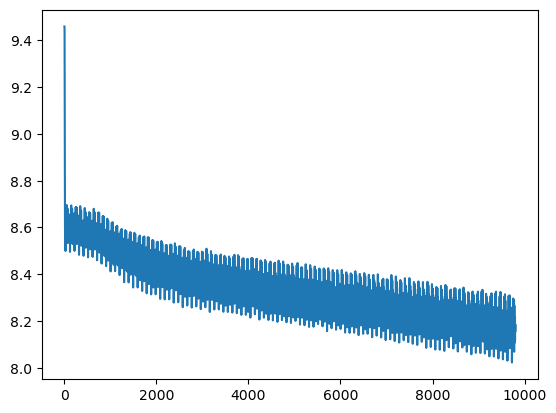

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loss')
plt.plot(program.losses, label='loss')
plt.legend
plt.show()